# <center>Fantom One Profit Smart Contract Analysis</center>


Fantom one profit is a __daily ROI project__, a [smart contract](https://ftmscan.com/address/0xf36cff29A1c92F5a8358DA21fA1f314023264634#code) deployed on fantom network. The game has two different plans with one offer 17% daily return for 7 days and the other offer 6% daily return for 30 days. 
<img src='images/fantom_one_profit_plans.png'>

The minimum investment is 5 FTM. The initial investment is locked away and will never be returned. The investor can withdraw and reinvest anytime. When people invest in the contract, the contract balance grows. When the contract balance goes to zero, the contract ends and there is nothing left for investor to withdraw. The contract was created on 2/17/2022 and the contract balance went to zero on 3/8/2022 even though there are still people trying to invest and withdraw from the contract as of 3/22/2022. The [website](https://fantomoneprofit.site/) is still available with the contract developers launching similar projects.

The purpose of this notebook is to preform __on-chain analysis__ to study the statistical characteristics of this daily ROI project and to understand:
* Profit and loss distribution among contract participants
* Investor behaviors

This contract is similar in its concept to stable one v2 contract on polygon network but it is a little less sophisticated. The analysis is also pretty similar. As most of daily ROI project, fantom one profit is more like a ponzi and only early investors can be profitable. Also the contract creators ("ceo" and "dev" as coded in the smart contract) makes money.
<table><tr>
<td> <img src="images/fantom_one_payout.png"/></td>
<td> <img src="images/fantom_one_return_dist_by_date.png"/> </td>
</tr></table>


In [1]:
import pandas as pd
import asyncio
import aiohttp
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

### Helper Functions

Provide a valid polyganscan API key below to run the notebook. You can obtain a free API key from https://ftmscan.com/apis

In [2]:
FANTOM_API_KEY="YOUR API KEY GOES HERE..."
FANTOM_PREFIX="https://api.ftmscan.com/"

In [3]:
# increase the data rate limit to run the program if needed
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

async def get_all_normal_transactions(prefix, apikey, address, startblock=0):
    """
    prefix: json-rpc 
    apikey: API key
    address: the address to sell all transactions
    startblock: it is not recommended to using 0. BSC has no problem. Polygon sometimes would complain the range is too large. 
                So start with a block number just before contract creation.
                
    return: list of transactions.
    """
    count = 10000

    output = []
    # API only return 10000 results at a time. So we have to loop
    while count > 9999:
        async with aiohttp.ClientSession() as session:
            url = f"{prefix}api?module=account&action=txlist&address={address}&startblock={startblock}&endblock=99999999&sort=asc&apikey={apikey}"
            #print(url)
            async with session.get(url) as resp:
                ret = await resp.json()
        
        if ret['status'] == '1':
            output.extend(ret['result'])      
            count = len(ret['result'])
            startblock = ret['result'][count - 1]['blockNumber']
        else:
            print("error.", ret)
            count = 0
    
    return output


# TODO: refactor the code as the main difference between the two are url...
async def get_all_internal_transactions(prefix, apikey, address, startblock=0):
    """
    prefix: json-rpc
    apikey: API key
    address: the address to sell all transactions
    startblock: it is not recommended to using 0. BSC has no problem. Polygon sometimes would complain the range is too large. 
                So start with a block number just before contract creation.
                
    return: list of transactions.
    """
    count = 10000

    output = []
    # API only return 10000 results at a time. So we have to loop
    while count > 9999:
        async with aiohttp.ClientSession() as session:
            url = f"{prefix}api?module=account&action=txlistinternal&address={address}&startblock={startblock}&endblock=99999999&sort=asc&apikey={apikey}"
            #print(url)
            async with session.get(url) as resp:
                ret = await resp.json()
        
        if ret['status'] == '1':
            output.extend(ret['result'])      
            count = len(ret['result'])
            startblock = ret['result'][count - 1]['blockNumber']
        else:
            print("error.", ret)
            count = 0
    
    return output

### Get all transactions for 0xf36cff29A1c92F5a8358DA21fA1f314023264634 - fantom one profit smart contract

In [4]:
# contract address
FANTOM_ONE_PROFIT_CONTRACT = "0xf36cff29A1c92F5a8358DA21fA1f314023264634".lower()

# use a block no that is a little bit earlier than contract creation
START_BLOCK_NO = 30088200

output = await get_all_normal_transactions(prefix=FANTOM_PREFIX, 
                                           apikey=FANTOM_API_KEY, 
                                           address=FANTOM_ONE_PROFIT_CONTRACT, 
                                           startblock=START_BLOCK_NO)

# Put data in dataframe and Remove duplicates
all_tx = pd.DataFrame.from_dict(output)
all_tx = all_tx.drop_duplicates(subset = ['hash'], keep = 'last').reset_index(drop = True)
all_tx = all_tx[all_tx['isError'] == '0']

all_tx.tail(10)

,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
42920,34147152,1647994726,0xa14ef56e52aac7b6cba033a53d9746b4b8720860c0eb...,13,0x0001755800000c6ccce2bd333a3457dd008b334e17d8...,4,0x6611b9bc881bc38e47589680cec8aaf6c935c2a4,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,99556,617406800000,0,1,0x3ccfd60b,,1464854,99556,1941
42921,34147209,1647994774,0x19fbd66c118f8675ed8542a77c99955297649439f0b4...,18,0x0001755800000ee2cb604a41a6412888bf6e8eac8b08...,40,0x62b01eca373fc8438ac566295d4566b8844ddf40,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,47521,596811300000,0,1,0x3ccfd60b,,4051786,43321,1884
42922,34147763,1647995304,0x080c899cad3e40a6831937e5eb9a68f08a172a186670...,16,0x0001755a00000ac30812f891eac114d2e91f0f959f71...,1,0xf0bf0c6499efd743740f72e229e06dab58659538,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,96030,474655000000,0,1,0x3ccfd60b,,111382,67221,1330
42923,34147895,1647995442,0x39576af3c0920e996924a55aaca32f515fb306ab6e7f...,18,0x0001755b000000b4df832f9e4cc28a41e51fb620f345...,22,0x2b9187a2f045305f7feb35032f7e46357c188d03,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,138955,472906300000,0,1,0x3ccfd60b,,2050782,97268,1198
42924,34147971,1647995514,0x49028f7e69c7b5fae496bdad1b1b00f9f7b6e76442e6...,13,0x0001755b0000041afe7859fea69ec33c93bc32901ba7...,0,0x06542c19bd50d74dd4354ed9963b89ed0af91a73,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,138507,463821200000,0,1,0x3ccfd60b,,96954,96954,1122
42925,34147997,1647995537,0x565cab15f305bfd8705969311234cccff93e1b7d2c02...,14,0x0001755b000005292bd869425afdc5444cd3a8c58f9a...,0,0x06542c19bd50d74dd4354ed9963b89ed0af91a73,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,138507,463821200000,0,1,0x3ccfd60b,,71662,71662,1096
42926,34148183,1647995713,0x4b0db64ddafd50478465aedf132d7f3d919fea990303...,6,0x0001755c000000683a2e0476116d695c153d2a58776a...,26,0xc8c579426dafafa7db54b00aae6e645b5fa4af56,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,135276,412339200000,0,1,0x3ccfd60b,,3943342,94693,910
42927,34148194,1647995727,0xd4f2f267660448049349547b806173c4702d02724e24...,15,0x0001755c000000f8d23eb356ed6ce694bcc2f4fc2c0a...,25,0x06542c19bd50d74dd4354ed9963b89ed0af91a73,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,103353,398003200000,0,1,0x3ccfd60b,,4784023,68147,899
42928,34148811,1647996349,0x43aaa7b8afe8d8e8a4d967ddc41c61fef2803d43bec6...,1,0x0001755e000008c2cf1d86ad6d0ce54f6da7dd8ba0ca...,1,0x7b0da45820b18471b0c26e6473338646efb13aa2,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,106435,391963900000,0,1,0x3ccfd60b,,197056,74504,282
42929,34148986,1647996512,0x5d008190a48b902dd9af464eb80fad24a7efea5a7d20...,127,0x0001755f000002d6bb1de201bf6cf1d93b6bab3ca924...,31,0x973eb17fa913f00178d9086336b86e6657f5cdbc,0xf36cff29a1c92f5a8358da21fa1f314023264634,0,83156,436271800000,0,1,0x3ccfd60b,,2853567,78956,107


#### Let's group transactions together
We are most interested in "Withdraw" and "Invest" calls. The method id are 0x3ccfd60b and 0x581c5ae6. These methods can be found on the transaction history on fantomscan

In [5]:
WITHDRAW_METHODID = '0x3ccfd60b'
INVEST_METHODID = '0x581c5ae6'

In [6]:
all_invest = all_tx[all_tx.input.str.startswith(INVEST_METHODID)]
all_withdraw = all_tx[all_tx.input == WITHDRAW_METHODID]

# convert to human readable format
DECIMAL = 1e18
all_invest['Investment'] = all_invest.value.astype(float)/DECIMAL
all_invest['UTC_Date'] = pd.to_datetime(all_invest.timeStamp, unit='s')

C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\davefang\.conda\envs\textmining\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Total FTM deposited:  1342190.062665382


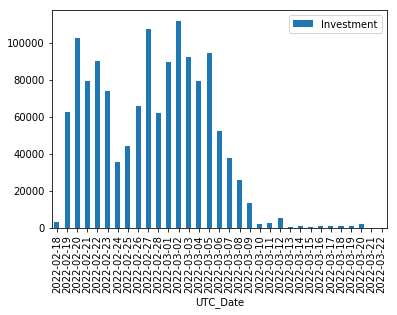

In [7]:
# How many FTM investment per day
df2 = all_invest.groupby(all_invest['UTC_Date'].dt.date).sum()
df2.plot.bar()
total_investment = df2.Investment.sum()
print("Total FTM deposited: ", total_investment)

### Get all internal tranasctions
The withdraw function transaction does not give out information about the withdraw amount. So we need to pull all internal transactions as internal transactions reveal the amount as well as where the money is going.

In [8]:
output2 = await get_all_internal_transactions(prefix=FANTOM_PREFIX, 
                                              apikey=FANTOM_API_KEY, 
                                              address=FANTOM_ONE_PROFIT_CONTRACT, 
                                              startblock=START_BLOCK_NO)

In [9]:
all_internal_tx = pd.DataFrame.from_dict(output2)
# For internal transactions, we could have the same transaction hash. To remove duplicates, we need also consider to address
#all_internal_tx = all_internal_tx.drop_duplicates(subset = ['blockNumber', 'hash', 'from', 'to', 'value'], keep = 'last').reset_index(drop = True)
# remove transaction that is reverted
all_internal_tx = all_internal_tx[all_internal_tx.isError == '0']

all_internal_tx['withdraw'] = all_internal_tx.value.astype(float)/DECIMAL
all_internal_tx['UTC_Date'] = pd.to_datetime(all_internal_tx.timeStamp, unit='s')

all_internal_tx.tail(10)

,blockNumber,timeStamp,hash,from,to,value,contractAddress,input,type,gas,gasUsed,traceId,isError,errCode,withdraw,UTC_Date
43951,34132141,1647978585,0x293752d8183b76ccb87072df8537ebfcbd7faefad4b3...,0x5f2c878cf53049751c7965ebb6cc7ab734477570,0xf36cff29a1c92f5a8358da21fa1f314023264634,8000000000000000000,,,call,136461,136461,,0,,8.00,2022-03-22 19:49:45
43952,34132141,1647978585,0x293752d8183b76ccb87072df8537ebfcbd7faefad4b3...,0xf36cff29a1c92f5a8358da21fa1f314023264634,0x5629c3e9371b77136f0c03ceadb9e76c8db7ab00,640000000000000000,,,call,136461,0,0,0,,0.64,2022-03-22 19:49:45
43953,34132141,1647978585,0x293752d8183b76ccb87072df8537ebfcbd7faefad4b3...,0xf36cff29a1c92f5a8358da21fa1f314023264634,0xbb4ad0ef2fcc13d226dfd2c101544709ebf33287,320000000000000000,,,call,136461,0,1,0,,0.32,2022-03-22 19:49:45
43954,34132141,1647978585,0x293752d8183b76ccb87072df8537ebfcbd7faefad4b3...,0xf36cff29a1c92f5a8358da21fa1f314023264634,0x5629c3e9371b77136f0c03ceadb9e76c8db7ab00,400000000000000000,,,call,136461,0,2,0,,0.40,2022-03-22 19:49:45
43955,34132169,1647978608,0xfc9e9e1a981a132e2874db2652566cf8670d5bf5d2a7...,0xf36cff29a1c92f5a8358da21fa1f314023264634,0x2017143f4816c7bc193c60a17c4f147695277b74,6640000000000000000,,,call,146038,0,0,0,,6.64,2022-03-22 19:50:08
43956,34135706,1647982860,0x95d82d53199970f411dd1250d985b1c4d674064f3e5c...,0x1cf8423299241f155716eb19d0ca65bea4353f03,0xf36cff29a1c92f5a8358da21fa1f314023264634,90000000000000000000,,,call,117224,117224,,0,,90.00,2022-03-22 21:01:00
43957,34135706,1647982860,0x95d82d53199970f411dd1250d985b1c4d674064f3e5c...,0xf36cff29a1c92f5a8358da21fa1f314023264634,0x5629c3e9371b77136f0c03ceadb9e76c8db7ab00,7200000000000000000,,,call,117224,0,0,0,,7.20,2022-03-22 21:01:00
43958,34135706,1647982860,0x95d82d53199970f411dd1250d985b1c4d674064f3e5c...,0xf36cff29a1c92f5a8358da21fa1f314023264634,0xbb4ad0ef2fcc13d226dfd2c101544709ebf33287,3600000000000000000,,,call,117224,0,1,0,,3.60,2022-03-22 21:01:00
43959,34135706,1647982860,0x95d82d53199970f411dd1250d985b1c4d674064f3e5c...,0xf36cff29a1c92f5a8358da21fa1f314023264634,0x5629c3e9371b77136f0c03ceadb9e76c8db7ab00,4500000000000000000,,,call,117224,0,2,0,,4.50,2022-03-22 21:01:00
43960,34135721,1647982877,0x43165b2270426135587ec92e3c5d457f29b5b83f504a...,0xf36cff29a1c92f5a8358da21fa1f314023264634,0x2017143f4816c7bc193c60a17c4f147695277b74,74700000000000000000,,,call,146038,0,0,0,,74.70,2022-03-22 21:01:17


#### Divide internal transactions (transfer transactions) into different wallets/categories
Based on solidity code, CEO takes 8%, Dev takes 4% for deposit and investment, the rest goes to the contract

In [10]:
# make sure the address copied are lower case
CEO_WALLET = '0x5629C3E9371B77136F0c03ceAdb9E76c8dB7Ab00'.lower()
DEV_WALLET = '0xBB4aD0Ef2FcC13D226dfd2C101544709eBF33287'.lower()

ceo_wallet_tx = all_internal_tx[all_internal_tx.to == CEO_WALLET]
dev_wallet_tx = all_internal_tx[all_internal_tx.to == DEV_WALLET]
user_withdraw = all_internal_tx[~all_internal_tx.to.isin([CEO_WALLET, DEV_WALLET])]
user_withdraw = user_withdraw[user_withdraw['from'] == FANTOM_ONE_PROFIT_CONTRACT]

In [11]:
df3 = user_withdraw.groupby(user_withdraw['UTC_Date'].dt.date).sum()
df4 = ceo_wallet_tx.groupby(ceo_wallet_tx['UTC_Date'].dt.date).sum()
df5 = dev_wallet_tx.groupby(dev_wallet_tx['UTC_Date'].dt.date).sum()
# create a data frame that combines total investment, user withdraw, ceo withdraw, dev withdraw
df = pd.concat([df2, df3, df4, df5], axis=1)
df.columns.values[2] = "ceo pay"
df.columns.values[3] = "dev pay"

### Analysis

Total FTM investment by investor: 1342190.062665382, (100.00%)
Total FTM withdrawn by investor: 1154583.333219148, (86.02%)
Total FTM paid out to ceo: 135902.67920368782, (10.13%)
Total FTM paid out to dev: 53629.704506615286, (4.00%)


Text(0.5,1,'Where did all the investment go?')

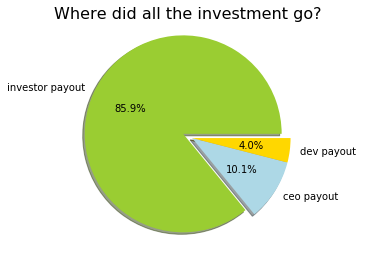

In [12]:
print(f"Total FTM investment by investor: {df['Investment'].sum()}, ({df['Investment'].sum()/total_investment*100 :0.2f}%)")
print(f"Total FTM withdrawn by investor: {df['withdraw'].sum()}, ({df['withdraw'].sum()/total_investment*100 :0.2f}%)")
print(f"Total FTM paid out to ceo: {df['ceo pay'].sum()}, ({df['ceo pay'].sum()/total_investment*100 :0.2f}%)")
print(f"Total FTM paid out to dev: {df['dev pay'].sum()}, ({df['dev pay'].sum()/total_investment*100 :0.2f}%)")
labels = ['investor payout', 'ceo payout', 'dev payout']
payout = [df['withdraw'].sum(), df['ceo pay'].sum(), df['dev pay'].sum()]
plt.pie(payout, labels=labels, autopct='%1.1f%%', colors=['yellowgreen', 'lightblue', 'gold'], 
        startangle=0, explode=(0.1, 0, 0), shadow=True)
plt.axis('equal')
plt.title('Where did all the investment go?', fontsize=16)

Text(0.5,0.98,'Daily Investment and Withdraw Distribution')

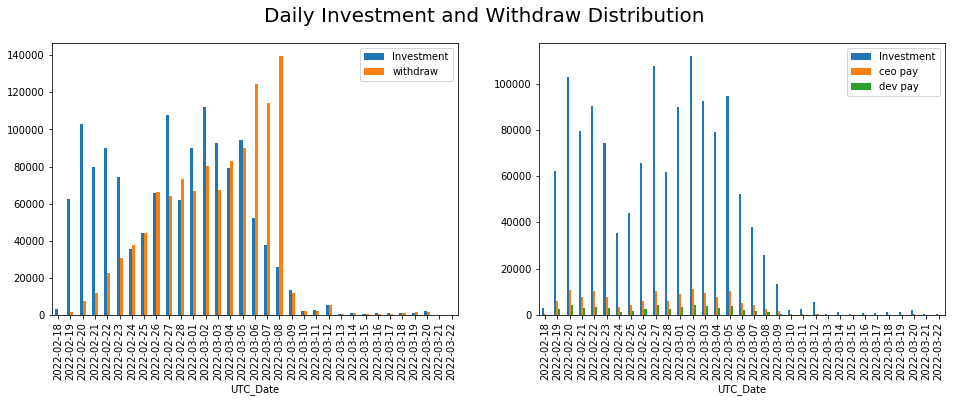

In [13]:
fig, ax = plt.subplots(1,2)
df[['Investment', 'withdraw']].plot.bar(ax=ax[0])
df[['Investment', 'ceo pay', 'dev pay']].plot.bar(ax=ax[1])
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle('Daily Investment and Withdraw Distribution', fontsize=20)

In [14]:
# let's reconstruct contract balance overtime
df['daily gain or drain'] = df['Investment'] - df['withdraw'] - df['ceo pay'] - df['dev pay']
df['contract balance'] = df['daily gain or drain'].cumsum()

Text(0.5,0.98,'Daily contract balance and daily change')

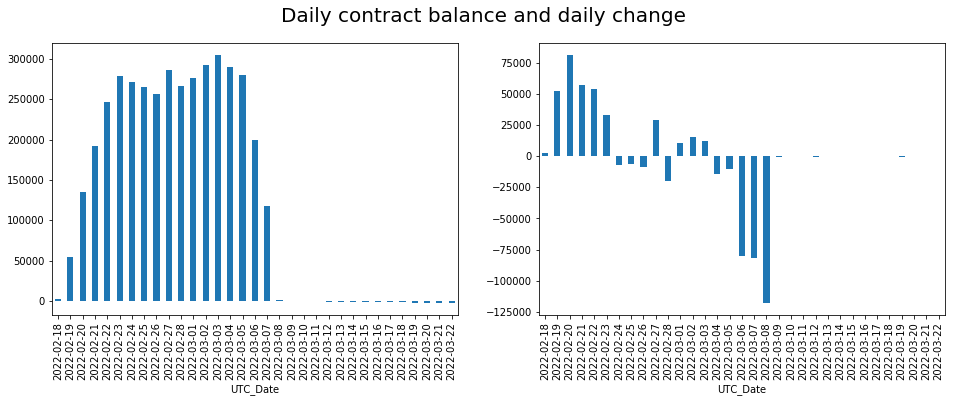

In [15]:
fig, ax = plt.subplots(1,2)
df['contract balance'].plot.bar(ax=ax[0])
df['daily gain or drain'].plot.bar(ax=ax[1])
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle('Daily contract balance and daily change', fontsize=20)

#### Let's also examine which user has made money and which user are still trying to make the first deposit back

Out of total 3648 players, 2113 players, or  57.92%, lost money
874 players lost all their money
1535 players break even at least
589 players made more than 19%, return for 7 day plan
74 players made more than 80%, return for 30 day plan


Text(0.5,1,'Investor Return Historgram')

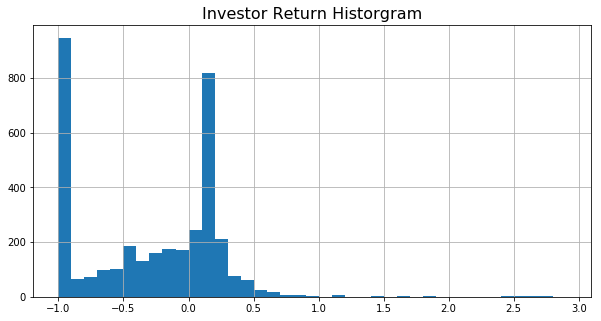

In [16]:
user_deposit_by_user = all_invest.groupby(all_invest['from'])['Investment'].sum()
user_withdraw_by_user = user_withdraw.groupby(user_withdraw['to'])['withdraw'].sum()

user = pd.concat([user_deposit_by_user, user_withdraw_by_user], axis=1)
user['withdraw'] = user['withdraw'].fillna(0)
user.dropna(inplace=True)

user['return'] = user.withdraw / user.Investment - 1.0
negative_returns = np.sum(user['return']<0)
print(f"Out of total {user.shape[0]} players, {negative_returns} players, or {negative_returns/user.shape[0]*100 : .2f}%, lost money")
print(f"{np.sum(user['return'] == -1)} players lost all their money")
print(f"{np.sum(user['return'] >= 0)} players break even at least")
print(f"{np.sum(user['return'] >= 0.19)} players made more than 19%, return for 7 day plan")
print(f"{np.sum(user['return'] >= 0.8)} players made more than 80%, return for 30 day plan")
hist = user['return'].hist(bins=[x/10.0 for x in range(-10, 30, 1)], figsize=(10,5))
hist.set_title('Investor Return Historgram', fontsize=16)

Text(0.5,1,'How much did each investor invest?')

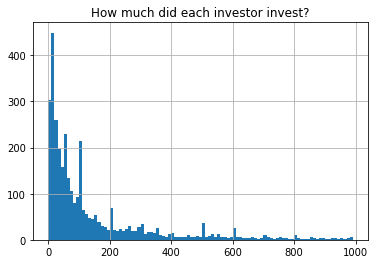

In [17]:
hist2 = user['Investment'].hist(bins=range(0, 1000, 10))
hist2.set_title("How much did each investor invest?")

In [18]:
# let's figure out when did investor first invest
user_earliest_investment_date = all_invest.groupby(all_invest['from'])['UTC_Date'].min()
user = pd.concat([user, user_earliest_investment_date], axis=1)

user.head(10)

,Investment,withdraw,return,UTC_Date
0x000a317f1ffd2d3a118c502bb91199b19287f89c,13.00000,15.470000,0.190000,2022-02-28 12:55:35
0x00149fa71a4e8bc0a194c7f2102b528181ce4425,52.80000,5.439103,-0.896987,2022-03-07 10:57:59
0x00565933b3670fd1155e77cd0461fadfe97fdb0e,170.00000,170.374451,0.002203,2022-02-21 10:40:08
0x0074e01a21e9934680c883f0b1231c7b3953a589,999.99999,869.449599,-0.130550,2022-02-27 05:47:30
0x008371cb1f09ea671afd6da961f865e550447527,200.00000,238.000000,0.190000,2022-02-22 22:22:14
0x0083badd1fb155a49c8332661521f15cc7739669,55.00000,18.587047,-0.662054,2022-03-01 22:11:59
0x0099fd51ae1c911c3be7fd95f2631dbf82e2dca8,7.00000,0.000000,-1.000000,2022-02-19 20:11:15
0x00a1c25053f65715343e4a76bd493aa55a28b392,25.00000,0.000000,-1.000000,2022-02-22 23:05:23
0x00a57122a265b729d8ed275f3c157e76dd3696b1,14.00000,0.000000,-1.000000,2022-03-15 00:05:47
0x00a74d2f8e9ba0c6915cc32dbcb2ef71ac6d906d,8379.00000,0.000000,-1.000000,2022-03-03 03:30:26


Text(0.5,1,'Investor Return Distribution based on first investment date')

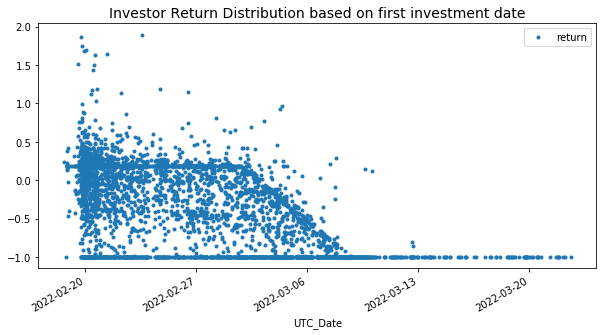

In [19]:
user2 = user[user['return'] < 2]
fig = user2.plot(x='UTC_Date', y='return', style='.', figsize=(10, 5))
fig.set_title('Investor Return Distribution based on first investment date', fontsize=14)

The return chart is a little suprising as there are early investors who have lost all the money. Maybe they never withdrew and just kept reinvest the money. For 30-day plan, as long as you withdraw, you get pricipal back on 17th day. The contract launched on 2/17/2022 and lasted about 20 days.

In [20]:
ug = user.groupby(user['UTC_Date'].dt.date).count()
ugn = user[user['return']<0].groupby(user['UTC_Date'].dt.date).count()
df6 = pd.concat([ug['return'], ugn['return']], axis=1)
df6.columns.values[0] = 'Total Investor'
df6.columns.values[1] = 'Total Negative Returns'
df6['% positive return'] = 100 - df6['Total Negative Returns'] / df6['Total Investor'] * 100
df6['% negative return'] = df6['Total Negative Returns'] / df6['Total Investor'] * 100

Text(0.5,0.98,'Investor Distribution based on first investment day')

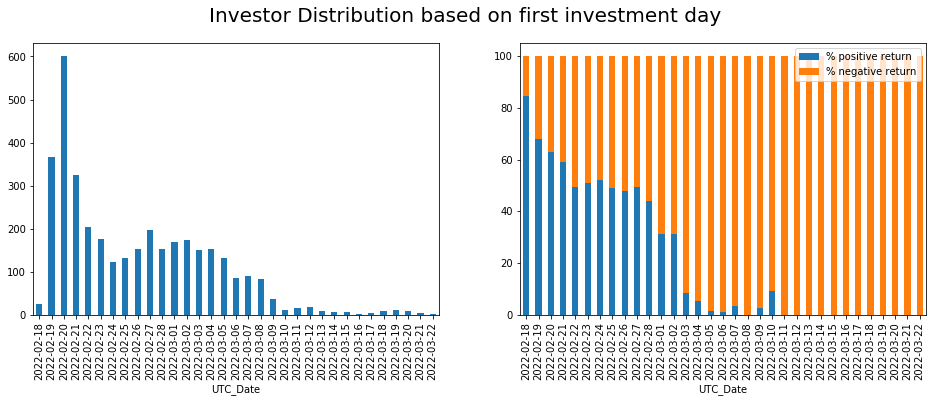

In [21]:
fig, ax = plt.subplots(1,2)
df6['Total Investor'].plot.bar(ax=ax[0])
df6[['% positive return', '% negative return']].plot.bar(stacked=True, ax=ax[1])
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle('Investor Distribution based on first investment day', fontsize=20)